In [1]:
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from utils import sparse_accuracy_ignoring_last_label, sparse_crossentropy_ignoring_last_label, Jaccard
from data_scripts.segmentation_generator import SegmentationGenerator
from data_scripts.data_loader import DataLoader
from utils import plot_prediction
from model import Deeplabv3
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [2]:

BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "data")
PASCAL_ROOT = os.path.join(DATA_DIR, "VOCdevkit", "VOC2012")
IMGS_PATH = os.path.join(PASCAL_ROOT, "JPEGImages")

SEED = np.random.randint(0, 1000)
IMG_SIZE = (512, 512)
BATCH_SIZE = 1
BUFFER_SIZE = 1000
EPOCHS = 30

In [3]:

#train_generator = SegmentationGenerator(root_folder=PASCAL_ROOT, mode="train", n_classes=21, resize_shape=IMG_SIZE, seed=SEED)
dataloader_train = DataLoader(
    root_folder=PASCAL_ROOT,
    mode="train",
    image_size=IMG_SIZE,
    channels=(3, 1),
    augment=False,
    compose=False,
    seed=SEED, 
    reshape_masks=True)

train_generator = dataloader_train.data_batch(batch_size=BATCH_SIZE, shuffle=True)

dataloader_val = DataLoader(
    root_folder=PASCAL_ROOT, 
    mode="val", 
    image_size=IMG_SIZE, 
    channels=(3, 1), 
    augment=False, 
    compose=False, 
    seed=SEED, 
    reshape_masks=True)
    
val_generator = dataloader_val.data_batch(batch_size=BATCH_SIZE, shuffle=True)


In [4]:
for images, masks in train_generator.take(2):
    sample_image, sample_mask = images[0], masks[0]
    sample_mask = np.reshape(sample_mask, (*IMG_SIZE, 1))
    #plot_prediction([sample_image, sample_mask])


class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # clear_output(wait=True)
        plot_prediction([sample_image, sample_mask], only_prediction=False, show_overlay=False)
        print('\nSample Prediction after epoch {}\n'.format(epoch+1))

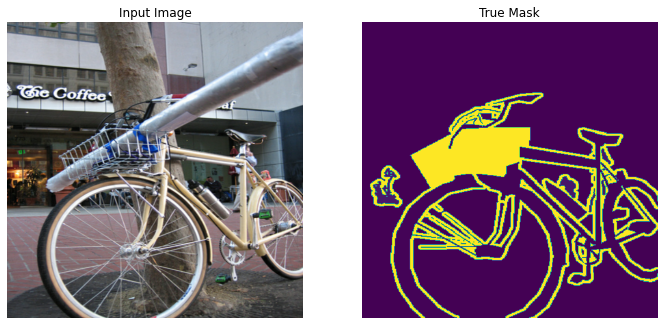

{0: 179946, 2: 34055, 5: 1455, 15: 1036, 16: 1168, 255: 44484}


In [5]:
plot_prediction([sample_image, sample_mask], only_prediction=False, show_overlay=False)
values, count = np.unique(sample_mask, return_counts=True)
print(dict(zip(values, count)))

In [6]:
model = Deeplabv3(
    input_shape=(512, 512, 3), 
    classes=21, 
    OS=16, 
    activation=None, 
    reshape_outputs=True)

In [7]:
losses = sparse_crossentropy_ignoring_last_label
metrics = [Jaccard, sparse_accuracy_ignoring_last_label]
optimizer=Adam(learning_rate=1e-5, epsilon=1e-8, decay=1e-6)
#losses = SparseCategoricalCrossentropy(from_logits=True)
#metrics = "accuracy"

model.compile(optimizer=optimizer, sample_weight_mode="temporal",
              loss=losses, metrics=metrics, run_eagerly=True)


EPOCHS = 30

callbacks = [
    DisplayCallback(),
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=3, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model_unet.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

model_history = model.fit(train_generator, epochs=EPOCHS,
                          validation_data=val_generator,
                          callbacks=callbacks)

Epoch 1/30
Y_true:(1, 262144, 1)
Y_pred:(1, 262144, 21)
(1, 262144)
   1/1464 [..............................] - ETA: 3:47:01 - loss: 2.0087 - Jaccard: 0.4762 - sparse_accuracy_ignoring_last_label: 0.7198Y_true:(1, 262144, 1)
Y_pred:(1, 262144, 21)
(1, 262144)
   2/1464 [..............................] - ETA: 19:48 - loss: 2.5850 - Jaccard: 0.3139 - sparse_accuracy_ignoring_last_label: 0.5422  Y_true:(1, 262144, 1)
Y_pred:(1, 262144, 21)
(1, 262144)
   3/1464 [..............................] - ETA: 19:50 - loss: 2.3213 - Jaccard: 0.4221 - sparse_accuracy_ignoring_last_label: 0.6390Y_true:(1, 262144, 1)
Y_pred:(1, 262144, 21)
(1, 262144)
   4/1464 [..............................] - ETA: 19:50 - loss: 2.2683 - Jaccard: 0.4527 - sparse_accuracy_ignoring_last_label: 0.6314Y_true:(1, 262144, 1)
Y_pred:(1, 262144, 21)
(1, 262144)
   5/1464 [..............................] - ETA: 20:02 - loss: 2.1735 - Jaccard: 0.4516 - sparse_accuracy_ignoring_last_label: 0.6684Y_true:(1, 262144, 1)
Y_pred:(